# Section 5a: Job Arrival Analysis

In [1]:
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from datetime import date, datetime, time, timedelta
import time, datetime, pytz
from datetime import datetime

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'libertine'

In [3]:
df = pd.read_parquet(path_job_dataset)
df

,id,submit_date,start_date,end_date,node,nodetypes,numnodes,numcores,state
0,1,2021-12-26 17:11:18,2021-12-26 23:06:31,2021-12-31 23:06:50,r13n5,normal,1,16,TIMEOUT
1,2,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r14n27,normal,1,16,TIMEOUT
2,3,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r15n12,normal,1,16,TIMEOUT
3,4,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n14,normal,1,16,TIMEOUT
4,5,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n30,normal,1,16,TIMEOUT
...,...,...,...,...,...,...,...,...,...
1596958,2323559,2022-11-01 13:55:57,2022-11-01 13:55:57,2022-11-01 13:58:54,r28n1,gpu_titanrtx_shared,1,6,CANCELLED
1596959,2323560,2022-11-01 13:56:12,2022-11-01 13:56:17,2022-11-01 13:56:24,r13n10,shared,1,6,FAILED
1596960,2323561,2022-11-01 13:56:45,2022-11-01 13:56:45,2022-11-01 13:58:12,r28n1,gpu_titanrtx_shared,1,6,FAILED
1596961,2323557,2022-11-01 13:54:21,2022-11-01 13:58:19,2022-11-01 13:59:01,r14n20,normal,1,16,COMPLETED


In [4]:
mark_ml_df(df)

# process column 'state'
df['state'] = df['state'].apply(lambda x: 'CANCELLED' if x is not None and x.startswith('CANCELLED') == True else x)

df["submit_day"] = df["submit_date"].dt.date
df["submit_hour_of_day"] = df["submit_date"].dt.hour
df["submit_day_of_week"] = df["submit_date"].apply(lambda x:x.weekday())

df['month_of_year'] = df["submit_date"].dt.month
df['week_of_year'] = df["submit_date"].apply(lambda x: x.strftime("%U"))
df['day_of_year'] = df["submit_date"].apply(lambda x: x.timetuple().tm_yday)
df["hour_of_year"] = df["submit_date"].apply(lambda x: int((x - datetime(x.year, 1, 1)).total_seconds() / 3600))
df["minute_of_year"] = df["submit_date"].apply(lambda x: int((x - datetime(x.year, 1, 1)).total_seconds() / 60))
df["second_of_year"] = df["submit_date"].apply(lambda x: int((x - datetime(x.year, 1, 1)).total_seconds()))

df["job_waiting_time"] = df["start_date"] - df["submit_date"]
df["job_waiting_time"] = df["job_waiting_time"].apply(lambda x:timedelta.total_seconds(x))
df["job_waiting_time"] = df["job_waiting_time"]/60/60 # hour

df["job_duration"] = df["end_date"] - df["start_date"]
df["job_duration"] = df["job_duration"].apply(lambda x:timedelta.total_seconds(x))
df["job_duration"] = df["job_duration"]/60/60 # hour

df["rack"] = df["node"].str.slice(0,3)

generic_df = df.loc[df["is_ml"] == 0]
ml_df = df.loc[df["is_ml"] == 1]
df

,id,submit_date,start_date,end_date,node,nodetypes,numnodes,numcores,state,split_nodes,...,submit_day_of_week,month_of_year,week_of_year,day_of_year,hour_of_year,minute_of_year,second_of_year,job_waiting_time,job_duration,rack
0,1,2021-12-26 17:11:18,2021-12-26 23:06:31,2021-12-31 23:06:50,r13n5,normal,1,16,TIMEOUT,{r13n5},...,6,12,52,360,8633,517991,31079478,5.920278,120.005278,r13
1,2,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r14n27,normal,1,16,TIMEOUT,{r14n27},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r14
2,3,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r15n12,normal,1,16,TIMEOUT,{r15n12},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r15
3,4,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n14,normal,1,16,TIMEOUT,{r10n14},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r10
4,5,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n30,normal,1,16,TIMEOUT,{r10n30},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596958,2323559,2022-11-01 13:55:57,2022-11-01 13:55:57,2022-11-01 13:58:54,r28n1,gpu_titanrtx_shared,1,6,CANCELLED,{r28n1},...,1,11,44,305,7309,438595,26315757,0.000000,0.049167,r28
1596959,2323560,2022-11-01 13:56:12,2022-11-01 13:56:17,2022-11-01 13:56:24,r13n10,shared,1,6,FAILED,{r13n10},...,1,11,44,305,7309,438596,26315772,0.001389,0.001944,r13
1596960,2323561,2022-11-01 13:56:45,2022-11-01 13:56:45,2022-11-01 13:58:12,r28n1,gpu_titanrtx_shared,1,6,FAILED,{r28n1},...,1,11,44,305,7309,438596,26315805,0.000000,0.024167,r28
1596961,2323557,2022-11-01 13:54:21,2022-11-01 13:58:19,2022-11-01 13:59:01,r14n20,normal,1,16,COMPLETED,{r14n20},...,1,11,44,305,7309,438594,26315661,0.066111,0.011667,r14


In [5]:
df['submit_day']

0          2021-12-26
1          2021-12-26
2          2021-12-26
3          2021-12-26
4          2021-12-26
              ...    
1596958    2022-11-01
1596959    2022-11-01
1596960    2022-11-01
1596961    2022-11-01
1596962    2022-11-01
Name: submit_day, Length: 1596963, dtype: object

In [6]:
ml_df["numnodes"].value_counts()

numnodes
1    189710
2       663
4        46
3        29
5        19
8         8
Name: count, dtype: int64

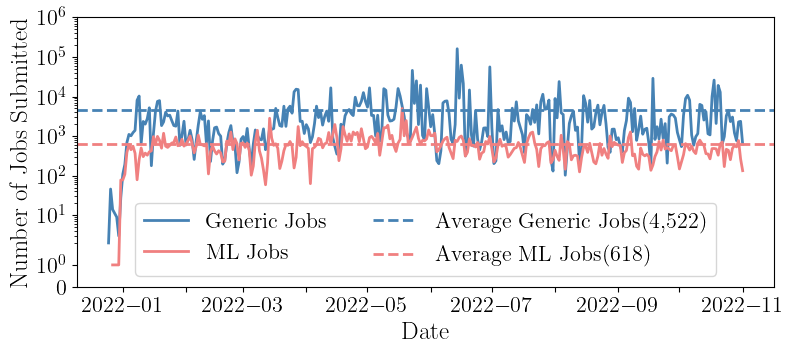

In [7]:
# Jobs submitted by date.
group_generic_df = generic_df.groupby(generic_df["submit_day"]).count().reset_index()
group_ml_df = ml_df.groupby(ml_df["submit_day"]).count().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(9, 3.5)

ax.plot(group_generic_df['submit_day'], group_generic_df['id'], color="steelblue", linewidth='2', label = "Generic Jobs")
ax.plot(group_ml_df['submit_day'], group_ml_df['id'], color="lightcoral", linewidth='2', label ="ML Jobs")
ax.axhline(group_generic_df['id'].mean(), label="Average Generic Jobs({:,.0f})".format(group_generic_df['id'].mean()), color="steelblue", linestyle="dashed", linewidth = 2)
ax.axhline(group_ml_df['id'].mean(), label="Average ML Jobs({:,.0f})".format(group_ml_df['id'].mean()), color="lightcoral", linestyle="dashed", linewidth = 2)

plt.yscale("symlog", subs = [1,2,3,4,5,6,7,8,9])
plt.ylim(bottom=1)
plt.ylim(top=5.5 * 10**5)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Jobs Submitted", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(ncol=2, prop={"size": 16}, loc="lower center")
ax.set_ylim(ymin=0, ymax=1000000)
for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)

plt.show()
fig.savefig('plots/section_5/fig-job-submitted-by-date.pdf', bbox_inches = 'tight')


In [8]:
generic_df.groupby(generic_df["month_of_year"]).count().reset_index()

,month_of_year,id,submit_date,start_date,end_date,node,nodetypes,numnodes,numcores,state,...,submit_hour_of_day,submit_day_of_week,week_of_year,day_of_year,hour_of_year,minute_of_year,second_of_year,job_waiting_time,job_duration,rack
0,1,87096,87096,87096,87096,87096,87096,87096,87096,87096,...,87096,87096,87096,87096,87096,87096,87096,87096,87096,87096
1,2,32777,32777,32777,32777,32777,32777,32777,32777,32777,...,32777,32777,32777,32777,32777,32777,32777,32777,32777,32777
2,3,98604,98604,98604,98604,98604,98604,98604,98604,98604,...,98604,98604,98604,98604,98604,98604,98604,98604,98604,98604
3,4,122165,122165,122165,122165,122165,122165,122165,122165,122165,...,122165,122165,122165,122165,122165,122165,122165,122165,122165,122165
4,5,241640,241640,241640,241640,241640,241640,241640,241640,241640,...,241640,241640,241640,241640,241640,241640,241640,241640,241640,241640
5,6,374011,374011,374011,374011,374011,374011,374011,374011,374011,...,374011,374011,374011,374011,374011,374011,374011,374011,374011,374011
6,7,93539,93539,93539,93539,93539,93539,93539,93539,93539,...,93539,93539,93539,93539,93539,93539,93539,93539,93539,93539
7,8,116234,116234,116234,116234,116234,116234,116234,116234,116234,...,116234,116234,116234,116234,116234,116234,116234,116234,116234,116234
8,9,90879,90879,90879,90879,90879,90879,90879,90879,90879,...,90879,90879,90879,90879,90879,90879,90879,90879,90879,90879
9,10,148811,148811,148811,148811,148811,148811,148811,148811,148811,...,148811,148811,148811,148811,148811,148811,148811,148811,148811,148811


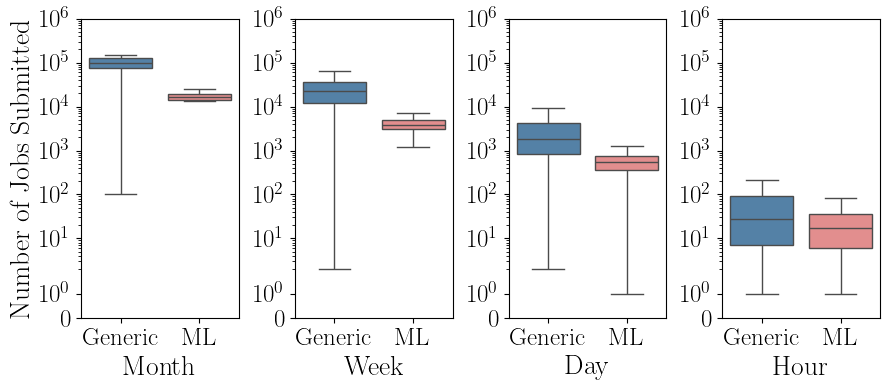

In [9]:
# Boxplot of jobs submitted.
fig, axes = plt.subplots(figsize = (9, 4), nrows = 1, ncols = 4)
boxprops= ["steelblue", "lightcoral"]

# month
group_generic_df = generic_df.groupby(generic_df["month_of_year"]).count().reset_index()
group_ml_df = ml_df.groupby(ml_df["month_of_year"]).count().reset_index()
group_generic_df['is_ml'] = 0
group_ml_df['is_ml'] = 1
df_concat = pd.concat([group_generic_df[['id', 'is_ml']], group_ml_df[['id', 'is_ml']]], axis=0)
sns.boxplot(data=df_concat, x='is_ml', y='id', hue='is_ml',  ax=axes[0], palette=boxprops, order=[0, 1], showfliers=False,  hue_order=[0, 1], dodge=False)

axes[0].set_ylim(ymin=0, ymax=1000000)
axes[0].xaxis.set_ticks([0, 1])
axes[0].set_xticklabels(['Generic', 'ML'])
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[0].set_ylabel('Number of Jobs Submitted', fontsize=20)
axes[0].set_yscale("symlog", subs = [1,2,3,4,5,6,7,8,9])
axes[0].set_xlabel("Month", fontsize=20)
axes[0].legend().remove()
# ylim 0 to 10**6 log scale

# week
group_generic_df = generic_df.groupby(generic_df["week_of_year"]).count().reset_index()
group_ml_df = ml_df.groupby(ml_df["week_of_year"]).count().reset_index()
group_generic_df['is_ml'] = 0
group_ml_df['is_ml'] = 1
df_concat = pd.concat([group_generic_df[['id', 'is_ml']], group_ml_df[['id', 'is_ml']]], axis=0)
sns.boxplot(data=df_concat, x='is_ml', y='id', hue='is_ml',  ax=axes[1], palette=boxprops, order=[0, 1], showfliers=False,  hue_order=[0, 1], dodge=False)
axes[1].set_ylim(ymin=0, ymax=1000000)
axes[1].xaxis.set_ticks([0, 1])
axes[1].set_xticklabels(['Generic', 'ML'])
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].set_ylabel('', fontsize=20)
axes[1].set_yscale("symlog", subs = [1,2,3,4,5,6,7,8,9])
axes[1].set_xlabel("Week", fontsize=20)
axes[1].legend().remove()

# day
group_generic_df = generic_df.groupby(generic_df["day_of_year"]).count().reset_index()
group_ml_df = ml_df.groupby(ml_df["day_of_year"]).count().reset_index()
group_generic_df['is_ml'] = 0
group_ml_df['is_ml'] = 1
df_concat = pd.concat([group_generic_df[['id', 'is_ml']], group_ml_df[['id', 'is_ml']]], axis=0)
sns.boxplot(data=df_concat, x='is_ml', y='id', hue='is_ml',  ax=axes[2], palette=boxprops, order=[0, 1], showfliers=False,  hue_order=[0, 1], dodge=False)
axes[2].set_ylim(ymin=0, ymax=1000000)
axes[2].xaxis.set_ticks([0, 1])
axes[2].set_xticklabels(['Generic', 'ML'])
axes[2].tick_params(axis='both', which='major', labelsize=18)
axes[2].set_ylabel('', fontsize=20)
axes[2].set_yscale("symlog", subs = [1,2,3,4,5,6,7,8,9])
axes[2].set_xlabel("Day", fontsize=20)
axes[2].legend().remove()

# hour
group_generic_df = generic_df.groupby(generic_df["hour_of_year"]).count().reset_index()
group_ml_df = ml_df.groupby(ml_df["hour_of_year"]).count().reset_index()
group_generic_df['is_ml'] = 0
group_ml_df['is_ml'] = 1
df_concat = pd.concat([group_generic_df[['id', 'is_ml']], group_ml_df[['id', 'is_ml']]], axis=0)
sns.boxplot(data=df_concat, x='is_ml', y='id', hue='is_ml',  ax=axes[3], palette=boxprops, order=[0, 1], showfliers=False,  hue_order=[0, 1], dodge=False)
axes[3].set_ylim(ymin=0, ymax=1000000)
axes[3].xaxis.set_ticks([0, 1])
axes[3].set_xticklabels(['Generic', 'ML'])
axes[3].tick_params(axis='both', which='major', labelsize=18)
axes[3].set_ylabel('', fontsize=20)
axes[3].set_yscale("symlog", subs = [1,2,3,4,5,6,7,8,9])
axes[3].set_xlabel("Hour", fontsize=20)
axes[3].legend().remove()

plt.tight_layout()
fig.savefig('plots/section_5/fig-job-submitted-boxplot.pdf', bbox_inches = 'tight')


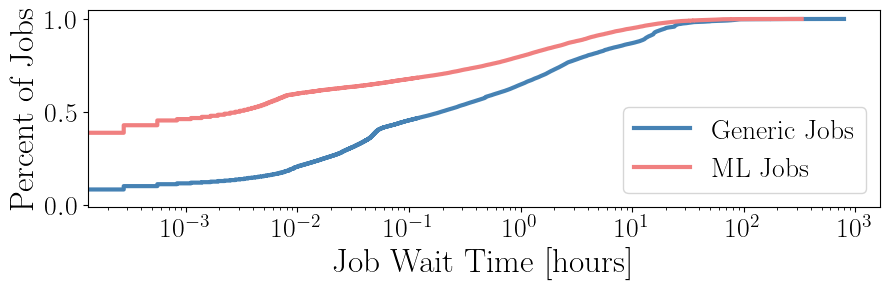

In [10]:
# job wait time (one figure)

def normalize(df):
    df = df['target'].value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df


def cdf(df_elapsed_values):
    all_values_df = pd.DataFrame({"target": df_elapsed_values["job_waiting_time"].values})
    count_df = normalize(all_values_df)
    counts = np.unique(df_elapsed_values["job_waiting_time"].values, return_counts=True)
    pdf = counts[1] / np.sum(counts[1])
    cdf = np.cumsum(pdf)
    return counts, cdf

ge_counts, ge_cdf = cdf(generic_df)
ml_counts, ml_cdf = cdf(ml_df)

fig = plt.figure(figsize=(9, 3))
plt.plot(ge_counts[0], ge_cdf, drawstyle='steps', color = 'steelblue', linewidth=3, label = "Generic Jobs")
plt.plot(ml_counts[0], ml_cdf, drawstyle='steps', color = 'lightcoral', linewidth=3, label = "ML Jobs")

# plt.xlim(-1,101)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc = "lower right", prop={'size': 20})
plt.xscale("log")
plt.xlabel("Job Wait Time [hours]", fontsize=24)
plt.ylabel("Percent of Jobs", fontsize=24)

plt.tight_layout()
plt.savefig('plots/section_5/fig-job-wait-time.pdf', bbox_inches = 'tight')


In [11]:
generic_df["job_duration"].describe()

count    1.406488e+06
mean     8.339245e-01
std      6.070081e+00
min      0.000000e+00
25%      5.555556e-04
50%      6.666667e-03
75%      8.527778e-02
max      1.220478e+02
Name: job_duration, dtype: float64

In [12]:
generic_df["job_duration"].quantile([0.90755])

0.90755    1.001111
Name: job_duration, dtype: float64

In [13]:
ml_df["job_duration"].quantile([0.7411])

0.7411    1.0
Name: job_duration, dtype: float64

In [14]:
ml_df["job_duration"].describe()

count    190475.000000
mean          2.705983
std           9.836977
min           0.000000
25%           0.007778
50%           0.108056
75%           1.005556
max         120.008333
Name: job_duration, dtype: float64

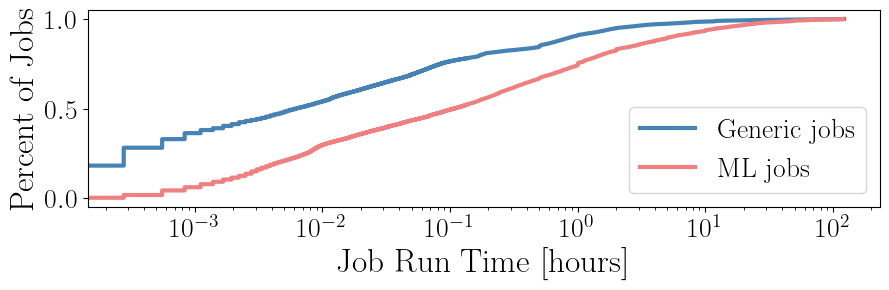

In [15]:
# job run time (one figure)

def normalize(df):
    df = df['target'].value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df


def cdf(df_elapsed_values):
    all_values_df = pd.DataFrame({"target": df_elapsed_values["job_duration"].values})
    count_df = normalize(all_values_df)
    counts = np.unique(df_elapsed_values["job_duration"].values, return_counts=True)
    pdf = counts[1] / np.sum(counts[1])
    cdf = np.cumsum(pdf)
    return counts, cdf

ge_counts, ge_cdf = cdf(generic_df)
ml_counts, ml_cdf = cdf(ml_df)

fig = plt.figure(figsize=(9, 3))
plt.plot(ge_counts[0], ge_cdf, drawstyle='steps', color = 'steelblue', linewidth=3, label = "Generic jobs")
plt.plot(ml_counts[0], ml_cdf, drawstyle='steps', color = 'lightcoral', linewidth=3, label = "ML jobs")

# plt.xlim(-1,101)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc = "lower right", prop={'size': 20})
plt.xscale("log")
plt.xlabel("Job Run Time [hours]", fontsize=24)
plt.ylabel("Percent of Jobs", fontsize=24)

plt.tight_layout()
plt.savefig('plots/section_5/fig-job-run-time.pdf', bbox_inches = 'tight')


In [16]:
xticks_labels = ax.get_xticklabels()
xticks_labels = [f'\n{label.get_text()}' if i % 2 == 1 else label.get_text() for i, label in enumerate(xticks_labels)]
xticks_labels


['$\\mathdefault{2022{-}01}$',
 '\n$\\mathdefault{2022{-}03}$',
 '$\\mathdefault{2022{-}05}$',
 '\n$\\mathdefault{2022{-}07}$',
 '$\\mathdefault{2022{-}09}$',
 '\n$\\mathdefault{2022{-}11}$']

/tmp/ipykernel_1920541/428589723.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_labels)


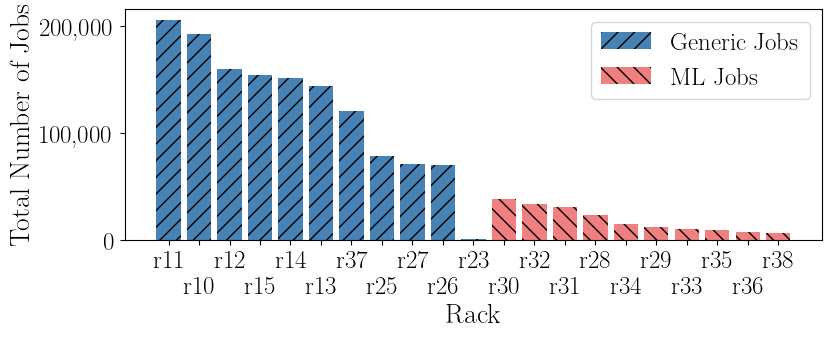

In [17]:
# Job distribution per rack
group_generic_df = generic_df.groupby('rack').count().reset_index()
group_generic_df = group_generic_df.sort_values(by=['id'],ascending=False)
group_generic_df = group_generic_df.drop(group_generic_df[group_generic_df['rack'] =='Non'].index)
group_generic_df = group_generic_df.drop(group_generic_df[group_generic_df['rack'] =='sof'].index)

group_ml_df = ml_df.groupby('rack').count().reset_index()
group_ml_df = group_ml_df.sort_values(by=['id'],ascending=False)

# fig = plt.figure(figsize=(9, 4))
fig,ax = plt.subplots(figsize = (9, 3))

#ax.bar(group_generic_df['rack'][1:12], group_generic_df['id'][1:12], color="steelblue", hatch="//", label = "Generic jobs")
ax.bar(group_generic_df['rack'], group_generic_df['id'], color="steelblue", hatch="//", label = "Generic Jobs")

ax.bar(group_ml_df['rack'], group_ml_df['id'], color="lightcoral", hatch="\\\\", label ="ML Jobs")

ax.legend(loc = "upper right", prop={'size': 18})
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel("Rack", fontsize=20)
plt.ylabel("Total Number of Jobs", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=18)

xticks_labels = ['r11',
 '\nr10',
 'r12',
 '\nr15',
 'r14',
 '\nr13',
 'r37',
 '\nr25',
 'r27',
 '\nr26',
 'r23',
 '\nr30',
 'r32',
 '\nr31',
 'r28',
 '\nr34',
 'r29',
 '\nr33',
 'r35',
 '\nr36',
 'r38']
ax.set_xticklabels(xticks_labels)


plt.show()
fig.savefig('plots/section_5/fig-rq4-job-distribution-per-rack.pdf', bbox_inches = 'tight')


In [18]:
xticks_labels = ax.get_xticklabels()
xticks_labels = [f'\n{label.get_text()}' if i % 2 == 1 else label.get_text() for i, label in enumerate(xticks_labels)]
xticks_labels


['r11',
 '\n\nr10',
 'r12',
 '\n\nr15',
 'r14',
 '\n\nr13',
 'r37',
 '\n\nr25',
 'r27',
 '\n\nr26',
 'r23',
 '\n\nr30',
 'r32',
 '\n\nr31',
 'r28',
 '\n\nr34',
 'r29',
 '\n\nr33',
 'r35',
 '\n\nr36',
 'r38']

/tmp/ipykernel_1920541/1771549478.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_labels)


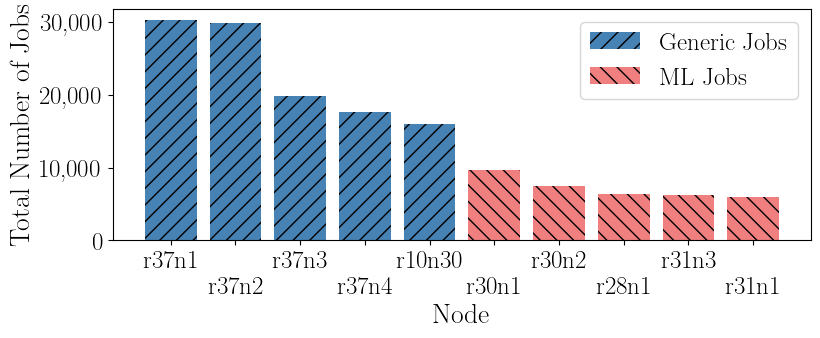

In [19]:
# Job distribution per node
group_generic_df = generic_df.groupby('node').count().reset_index()
group_generic_df = group_generic_df.sort_values(by=['id'],ascending=False)
group_generic_df = group_generic_df.drop(group_generic_df[group_generic_df['node'] =='None assigned'].index)
group_generic_df = group_generic_df.drop(group_generic_df[group_generic_df['node'] =='software 1'].index)
group_generic_df = group_generic_df.drop(group_generic_df[group_generic_df['node'] =='software 2'].index)
group_generic_df = group_generic_df.loc[group_generic_df["id"] >= 100]

group_ml_df = ml_df.groupby('node').count().reset_index()
group_ml_df = group_ml_df.sort_values(by=['id'],ascending=False)
group_ml_df = group_ml_df.drop(group_ml_df[group_ml_df['node'] =='None assigned'].index)
group_ml_df = group_ml_df.drop(group_ml_df[group_ml_df['node'] =='software 1'].index)
group_ml_df = group_ml_df.drop(group_ml_df[group_ml_df['node'] =='software 2'].index)
group_ml_df = group_ml_df.loc[group_ml_df["id"] >= 100]

fig,ax = plt.subplots(figsize = (9, 3))

plt.bar(group_generic_df['node'][0:5], group_generic_df['id'][0:5], color="steelblue", hatch="//", label = "Generic Jobs")
plt.bar(group_ml_df['node'][0:5], group_ml_df['id'][0:5], color="lightcoral", hatch="\\\\", label ="ML Jobs")

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc = "upper right", prop={'size': 18})
plt.xlabel("Node", fontsize=20)
plt.ylabel("Total Number of Jobs", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
xticks_labels =['r37n1',
 '\nr37n2',
 'r37n3',
 '\nr37n4',
 'r10n30',
 '\nr30n1',
 'r30n2',
 '\nr28n1',
 'r31n3',
 '\nr31n1']
ax.set_xticklabels(xticks_labels)

plt.show()
fig.savefig('plots/section_5/fig-rq4-job-distribution-per-node.pdf', bbox_inches = 'tight')

In [20]:
group_generic_df

,node,id,submit_date,start_date,end_date,nodetypes,numnodes,numcores,state,split_nodes,...,submit_day_of_week,month_of_year,week_of_year,day_of_year,hour_of_year,minute_of_year,second_of_year,job_waiting_time,job_duration,rack
10711,r37n1,30204,30204,30204,30204,30204,30204,30204,30204,30204,...,30204,30204,30204,30204,30204,30204,30204,30204,30204,30204
10712,r37n2,29904,29904,29904,29904,29904,29904,29904,29904,29904,...,29904,29904,29904,29904,29904,29904,29904,29904,29904,29904
10713,r37n3,19877,19877,19877,19877,19877,19877,19877,19877,19877,...,19877,19877,19877,19877,19877,19877,19877,19877,19877,19877
10714,r37n4,17605,17605,17605,17605,17605,17605,17605,17605,17605,...,17605,17605,17605,17605,17605,17605,17605,17605,17605,17605
969,r10n30,15929,15929,15929,15929,15929,15929,15929,15929,15929,...,15929,15929,15929,15929,15929,15929,15929,15929,15929,15929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,software2,827,827,827,827,827,827,827,827,827,...,827,827,827,827,827,827,827,827,827,827
8113,r15n32,774,774,774,774,774,774,774,774,774,...,774,774,774,774,774,774,774,774,774,774
9080,"r25n[18,20,23,24,27,28,32],r26n[17,19,23,25,26...",163,163,163,163,163,163,163,163,163,...,163,163,163,163,163,163,163,163,163,163
4228,"r11n[12,16]",137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137


In [21]:
generic_df["job_duration"].describe()

count    1.406488e+06
mean     8.339245e-01
std      6.070081e+00
min      0.000000e+00
25%      5.555556e-04
50%      6.666667e-03
75%      8.527778e-02
max      1.220478e+02
Name: job_duration, dtype: float64

In [22]:
ml_df["job_duration"].describe()

count    190475.000000
mean          2.705983
std           9.836977
min           0.000000
25%           0.007778
50%           0.108056
75%           1.005556
max         120.008333
Name: job_duration, dtype: float64